In [1]:
#needed to autoreload my functions
%load_ext autoreload

import json
import pickle

# import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#ML
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

import xgboost as xgb

import scipy as sp
## dont want warnings for final version
#import warnings
#warnings.filterwarnings("ignore")

#add this for auto reload my cuystom scripts
import sys
sys.path.append("..") ## to find my own libraries in src folder
# below I use param 1 to only reload funciton selected via %aimport. param 2 would reload everything
%autoreload 1
%aimport src.processing_functions
%aimport src.my_utils
from src import processing_functions as pf
from src import my_utils as mut



In [2]:
# import data

train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
print(train.shape)
print(test.shape)

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# remove Id col for further preprocessing
train_noid=train.drop('Id',axis=1)
test_noid=test.drop('Id',axis=1)

print(train_noid.shape)
print(test_noid.shape)

# lets also combine train and test for preprocessing
train_nodv=train_noid.drop(columns=["SalePrice"])#remove dv to concatenate
# put dv aside
y=train["SalePrice"]
y_log=np.log(y)
# add info about the original set to which data belongs
tmp_train=train_nodv.copy()
tmp_train["set_id"]="train"
tmp_test=test_noid.copy()
tmp_test["set_id"]="test"
all_data=pd.concat([tmp_train,tmp_test])

all_data.shape


(1460, 81)
(1459, 80)
(1460, 80)
(1459, 79)


(2919, 80)

# 1. apply pipeline

In [4]:
# the baseline pipeline
#1.fill nas
print("shape before ",all_data.shape)
tmp=pf.fill_false_nas(all_data)
tmp=pf.fill_true_nas(tmp)
# 2. remove outliers
tmp,y_no_out=pf.remove_outliers_picked(tmp,y)# extract y col wo outliers
# 3.normalize num cols
tmp=pf.normalize_min_max(tmp)
# 4. transform distribution of num features
tmp=pf.transform_distribution_features_simple(tmp)
#5. deal with categorical variables
tmp=pf.label_encoding_subset(tmp)
print(tmp["set_id"])
all_data_processed=pf.one_hot_encoding(tmp)
all_data_processed.shape

shape before  (2919, 80)
0       train
1       train
2       train
3       train
4       train
        ...  
1454     test
1455     test
1456     test
1457     test
1458     test
Name: set_id, Length: 2917, dtype: object


(2917, 220)

DVP the robust scaler

In [13]:
def normalize_robust(df: pd.DataFrame):
    """ applies robust scaler function from sklearn to 
    all numerical column in the dataframe
    
    requires:
    from sklearn.preprocessing import RobustScaler
    """
    tmp=df.copy()#copy to avoid modif original df
    # Check if all columns in the DataFrame are numeric
    # if not all(pd.api.types.is_numeric_dtype(tmp[col]) for col in tmp.columns):
    #     raise ValueError("All columns in the input DataFrame must be numeric")
    
    # separate num and categ vars
    tmpnum=tmp.select_dtypes(include="number")
    tmpcatag=tmp.select_dtypes(exclude="number")
    
    # instanciate scaler and fit
    scaler=RobustScaler().fit(tmpnum)
    # create scaled array
    scaled_array=scaler.transform(tmpnum)
    # convert back to dataframe
    tmpnum_norm = pd.DataFrame(scaled_array, columns=tmpnum.columns, index=tmpnum.index)

    #concat num and categ df
    tmp_norm=pd.concat([tmpnum_norm, tmpcatag], axis=1)
    return tmp_norm

In [14]:
# the baseline pipeline
#1.fill nas
print("shape before ",all_data.shape)
tmp=pf.fill_false_nas(all_data)
tmp=pf.fill_true_nas(tmp)
# 2. remove outliers
tmp,y_no_out=pf.remove_outliers_picked(tmp,y)# extract y col wo outliers
# 3. transform distribution of num features
tmp=pf.transform_distribution_features_simple(tmp)
#4. deal with categorical variables
tmp=pf.label_encoding_subset(tmp)
print(tmp["set_id"])
tmp=pf.one_hot_encoding(tmp)
# 5. robust scaling
all_data_processed=normalize_robust(tmp)

all_data_processed.shape

shape before  (2919, 80)
0       train
1       train
2       train
3       train
4       train
        ...  
1454     test
1455     test
1456     test
1457     test
1458     test
Name: set_id, Length: 2917, dtype: object


(2917, 220)

In [8]:
# 3.normalize num cols


tmpnum=tmp.select_dtypes(include="number")
tmpcatag=tmp.select_dtypes(exclude="number")

tmpnum.shape

(2917, 36)

In [5]:
scaler=RobustScaler().fit(tmpnum)
scaler

RobustScaler()

In [7]:
test=scaler.transform(tmpnum)
test.shape

(2917, 36)

In [10]:
type(test)

numpy.ndarray

In [12]:
tmpnum_scaled = pd.DataFrame(test, columns=tmpnum.columns, index=tmpnum.index)
tmpnum_scaled

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.2,-0.25,-0.245588,0.5,0.0,0.625000,0.256410,1.202454,0.461119,0.0,...,0.265625,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,-1.00,0.0
1,-0.6,0.50,0.036275,0.0,3.0,0.062500,-0.435897,0.000000,0.832196,0.0,...,-0.078125,1.773810,-0.371429,0.0,0.0,0.0,0.0,0.0,-0.25,-0.5
2,0.2,-0.10,0.440686,0.5,0.0,0.583333,0.230769,0.993865,0.160982,0.0,...,0.500000,0.000000,0.228571,0.0,0.0,0.0,0.0,0.0,0.75,0.0
3,0.4,-0.50,0.024020,0.5,0.0,-1.208333,-0.589744,0.000000,-0.207367,0.0,...,0.632812,0.000000,0.128571,272.0,0.0,0.0,0.0,0.0,-1.00,-1.0
4,0.2,0.70,1.178431,1.0,0.0,0.562500,0.179487,2.147239,0.391542,0.0,...,1.390625,1.142857,0.828571,0.0,0.0,0.0,0.0,0.0,1.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.2,-2.45,-1.842157,-1.0,2.0,-0.062500,-0.589744,0.000000,-0.502046,0.0,...,-1.875000,0.000000,-0.371429,0.0,0.0,0.0,0.0,0.0,0.00,-1.0
1455,2.2,-2.45,-1.852451,-1.0,0.0,-0.062500,-0.589744,0.000000,-0.158254,0.0,...,-0.757812,0.000000,-0.028571,0.0,0.0,0.0,0.0,0.0,-0.50,-1.0
1456,-0.6,4.50,2.585294,-0.5,2.0,-0.270833,0.076923,0.000000,1.167804,0.0,...,0.375000,2.821429,-0.371429,0.0,0.0,0.0,0.0,0.0,0.75,-1.0
1457,0.7,-0.40,0.242402,-0.5,0.0,0.395833,-0.025641,0.000000,-0.042292,0.0,...,-1.875000,0.476190,0.085714,0.0,0.0,0.0,0.0,700.0,0.25,-1.0


In [ ]:
tmpnum_norm=(tmpnum-tmpnum.min())/(tmpnum.max()-tmpnum.min())
#concat num and categ df
tmp_norm=pd.concat([tmpnum_norm, tmpcatag], axis=1)

In [ ]:
# the baseline pipeline
#1.fill nas
print("shape before ",all_data.shape)
tmp=pf.fill_false_nas(all_data)
tmp=pf.fill_true_nas(tmp)
# 2. remove outliers
tmp,y_no_out=pf.remove_outliers_picked(tmp,y)# extract y col wo outliers
# 3.normalize num cols
tmp=pf.normalize_min_max(tmp)
# 4. transform distribution of num features
tmp=pf.transform_distribution_features_simple(tmp)
#5. deal with categorical variables
tmp=pf.label_encoding_subset(tmp)
print(tmp["set_id"])
all_data_processed=pf.one_hot_encoding(tmp)
all_data_processed.shape

## Split training and validation set

In [ ]:
all_data_processed.shape

In [6]:
all_data_processed[all_data_processed["set_id"]=="train"].shape

#split training and test set
train_data_proc=all_data_processed[all_data_processed["set_id"]=="train"]
train_data_proc=train_data_proc.drop(columns=["set_id"])#rmv set_id col useless
test_data_proc=all_data_processed[all_data_processed["set_id"]=="test"]
# X_test=all_processed_data.drop(columns)
test_data_proc=test_data_proc.drop(columns=["set_id"])#rmv set_id col useless

print(train_data_proc.shape, test_data_proc.shape)


(1458, 219) (1459, 219)


In [7]:
y_no_out.shape

(1458,)

In [9]:
#apply log transform on dv
y_log=np.log(y_no_out)
X_train, X_val, y_train, y_val = train_test_split(train_data_proc, y_log, random_state=1,test_size=0.3)
print(X_train.shape,X_val.shape)

(1020, 219) (438, 219)


In [49]:
X_train_full=train_data_proc
y_train_full=y_log

# 2. train some models

## 2.1. XG boost

In [8]:
### just load model to save time
# # the grid search for best params. beware, time consuming to run

# # Define the model
# model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'alpha': [0, 0.1, 1],
#     'lambda': [1, 1.5, 2]
# }

# # Perform grid search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score: ", -grid_search.best_score_)

# # Train model with best parameters
# best_params = grid_search.best_params_
# best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
# best_model.fit(X_train, y_train)

# # Save best params to a JSON file
# with open('best_params_xgboost.json', 'w') as f:
#     json.dump(best_params, f)

# with open('grid_search_xgboost.pkl', 'wb') as f:
#     pickle.dump(grid_search, f)

NameError: name 'X_train' is not defined

In [52]:
with open('../models/best_params_xgboost.json', 'r') as f:
    xgb_best_params = json.load(f)

In [28]:
# instanciate model and fit
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Calculate RMSE for the training set
y_train_pred=best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Evaluate the model
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

final_xgb=best_model

Training RMSE:  0.06306652360476431
Validation RMSE:  0.12112116197137937


In [27]:
# instanciate model and fit
alphas=[0,0.0001,0.001,0.01,0.1]
for e in alphas:
    print("alpha =  ",e  )
    best_model = xgb.XGBRegressor(**best_params,reg_alpha=e, objective='reg:squarederror', random_state=42)
    best_model.fit(X_train, y_train)
    
    # Calculate RMSE for the training set
    y_train_pred=best_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    print("Training RMSE: ", rmse_train)
    
    # Evaluate the model
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print("Validation RMSE: ", rmse)

alpha =   0
Training RMSE:  0.06306652360476431
Validation RMSE:  0.12112116197137937
alpha =   0.0001
Training RMSE:  0.06315605758582941
Validation RMSE:  0.1211508689812278
alpha =   0.001
Training RMSE:  0.06349756358063
Validation RMSE:  0.1214668716798984
alpha =   0.01
Training RMSE:  0.06398516737666032
Validation RMSE:  0.12144955149997869
alpha =   0.1
Training RMSE:  0.06589594416082911
Validation RMSE:  0.12211553919712918


In [24]:
best_params

{'alpha': 0,
 'colsample_bytree': 0.7,
 'lambda': 1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.7}

In [ ]:
## let's do a new grid search, focusing on regularisation

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [ 300],
    'learning_rate': [0.05],
    'max_depth': [3,5],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'alpha': [0,0.001,0.01, 0.1, 1],
    'lambda': [1, 1.5, 2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Train model with best parameters
best_params = grid_search.best_params_
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Save best params to a JSON file
with open('best_params_xgboost.json', 'w') as f:
    json.dump(best_params, f)

with open('grid_search_xgboost.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

## 2.2. lasso

In [29]:
# Define the model with LassoCV
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, random_state=42)

# Train the model with cross-validation
lasso_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print("Best alpha: ", best_alpha)

# Make predictions on the training set
y_train_pred = lasso_cv.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Make predictions and evaluate the model
y_pred_cv = lasso_cv.predict(X_val)
mse_cv = mean_squared_error(y_val, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)
print("Validation RMSE with best alpha: ", rmse_cv)

Best alpha:  0.0004498432668969444
Training RMSE:  0.09643795763854057
Validation RMSE with best alpha:  0.12069833191185458


## 2.3. ridge

In [51]:
kr = GridSearchCV(
    KernelRidge(kernel="poly"),
    # ## best
    # param_grid={"alpha": [0.0002782559402207126],
    #             "gamma": [0.0001]
     ## best
    param_grid={"alpha": np.logspace(np.log10(0.0001),np.log10(1),10),
                "degree": [2],
                "coef0":np.linspace(100,1000,10)
               },
)
kr.fit(X_train,y_train)

#check best parameters
print("Best parameters found: ", kr.best_params_)
print("Best cross-validation MSE: ", -kr.best_score_)

#predict training set
y_train_pred=kr.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)



# Evaluate the model on the validation set
y_val_pred = kr.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print("Validation RMSE: ", rmse_val)


## save model and best params

kr_best_params =kr.best_params_

# Save best params to a JSON file
with open('../models/best_params_ridge.json', 'w') as f:
    json.dump(kr_best_params, f)

with open('../models/grid_search_ridge.pkl', 'wb') as f:
    pickle.dump(kr, f)


Best parameters found:  {'alpha': 1.0, 'coef0': 100.0, 'degree': 2}
Best cross-validation MSE:  -0.9174644543749075
Training RMSE:  0.08573643873736331
Validation RMSE:  0.12669797491545234


## 2.4. elastic net

In [55]:
from sklearn.linear_model import ElasticNet


# Define parameter grid
param_grid = {
    'alpha': np.logspace(np.log10(0.0001),np.log10(0.2),20),
    'l1_ratio': np.linspace(0.8, 1, 15)
}

# Instantiate mdoel
elastic_net = ElasticNet( )

# instantiate and fit grid search
elastic_net_cv = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elastic_net_cv.fit(X_train, y_train)

# Print best parameters and best score
elastic_net_best_params=elastic_net_cv.best_params_
print("Best parameters found: ", elastic_net_cv.best_params_)
print("Best cross-validation MSE: ", -elastic_net_cv.best_score_)



# Make predictions on the training set
y_train_pred = elastic_net_cv.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = elastic_net_cv.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

Best parameters found:  {'alpha': 0.0004953973547768393, 'l1_ratio': 1.0}
Best cross-validation MSE:  0.01228091982707741
Training RMSE:  0.0971481203792159
Validation RMSE:  0.12069546265589584


# 3. blending

## 31 3 models

In [46]:
#eval blended predictions on validation set

# Make predictions with each model
preds_kr = kr.predict(X_val)
preds_lasso_cv = lasso_cv.predict(X_val)
preds_final_xgb = final_xgb.predict(X_val)

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,], axis=0)

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, blended_preds)
rmse_val = np.sqrt(mse_val)
print("Validation RMSE: ", rmse_val)


Validation RMSE:  0.1171359948825713


In [42]:
# make pred and save in submission file

preds_kr = np.exp(kr.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_cv.predict(test_data_proc))
preds_final_xgb = np.exp(final_xgb.predict(test_data_proc))

blended_preds = np.mean([preds_kr, preds_lasso_cv, preds_final_xgb], axis=0)

# print(len(y_pred),len(test_data_proc))
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso.csv",index=False)

## use full training set

In [59]:
xgb_best = xgb.XGBRegressor(**xgb_best_params, objective='reg:squarederror', random_state=42)
xgb_best.fit(X_train_full, y_train_full)




XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, ...)

In [56]:
elastic_net_best = ElasticNet(**elastic_net_best_params )
elastic_net_best.fit(X_train_full, y_train_full)


ElasticNet(alpha=0.0004953973547768393, l1_ratio=1.0)

In [57]:
kr_best=KernelRidge(**kr_best_params)
kr_best.fit(X_train_full, y_train_full)

KernelRidge(alpha=1.0, coef0=100.0, degree=2)

In [60]:
lasso_best=Lasso(best_alpha)
lasso_best.fit(X_train_full, y_train_full)

Lasso(alpha=0.0004498432668969444)

In [61]:
## for 4 models
# Make the preds for test set and save them
# Make predictions with each model
preds_kr = np.exp(kr_best.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_best.predict(test_data_proc))
preds_final_xgb = np.exp(xgb_best.predict(test_data_proc))
preds_elastic_net_cv=np.exp(elastic_net_best.predict(test_data_proc))

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_elastic_net_cv], axis=0)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso,elast_fulltrain.csv",index=False)


In [62]:
## for 3 models
# Make the preds for test set and save them
# Make predictions with each model
preds_kr = np.exp(kr_best.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_best.predict(test_data_proc))
preds_final_xgb = np.exp(xgb_best.predict(test_data_proc))

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,], axis=0)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso_fulltrain.csv",index=False)


## 4 models

In [47]:
#eval blended predictions on validation set

# Make predictions with each model
preds_kr = kr.predict(X_val)
preds_lasso_cv = lasso_cv.predict(X_val)
preds_final_xgb = final_xgb.predict(X_val)
preds_elastic_net_cv=elastic_net_cv.predict(X_val)

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_elastic_net_cv], axis=0)

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, blended_preds)
rmse_val = np.sqrt(mse_val)
print("Validation RMSE: ", rmse_val)


Validation RMSE:  0.11750394083510789


In [48]:
# Make predictions with each model
preds_kr = np.exp(kr.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_cv.predict(test_data_proc))
preds_final_xgb = np.exp(final_xgb.predict(test_data_proc))
preds_elastic_net_cv=np.exp(elastic_net_cv.predict(test_data_proc))

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_elastic_net_cv], axis=0)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso,elast.csv",index=False)


# 4. stacking

## regression. training set

In [65]:
from sklearn.linear_model import LinearRegression

# Generate predictions from each base model on the training set
kr_train_pred = kr_best.predict(X_train)
xgb_train_pred = xgb_best.predict(X_train)
lasso_train_pred = lasso_best.predict(X_train)
elastic_net_train_pred = elastic_net_best.predict(X_train)

# Stack predictions to create a new feature set for the meta-model
stacked_train_pred = np.column_stack((kr_train_pred, xgb_train_pred, lasso_train_pred, elastic_net_train_pred))

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_train_pred, y_train)

# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(X_val)
xgb_test_pred = xgb_best.predict(X_val)
lasso_test_pred = lasso_best.predict(X_val)
elastic_net_test_pred = elastic_net_best.predict(X_val)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# Evaluate the performance of the stacked model
mse_val = mean_squared_error(y_val, final_predictions)
rmse_val = np.sqrt(mse_val)
print(f"Test RMSE of the stacked model: {test_rmse}")

Test RMSE of the stacked model: 0.07675538295317386


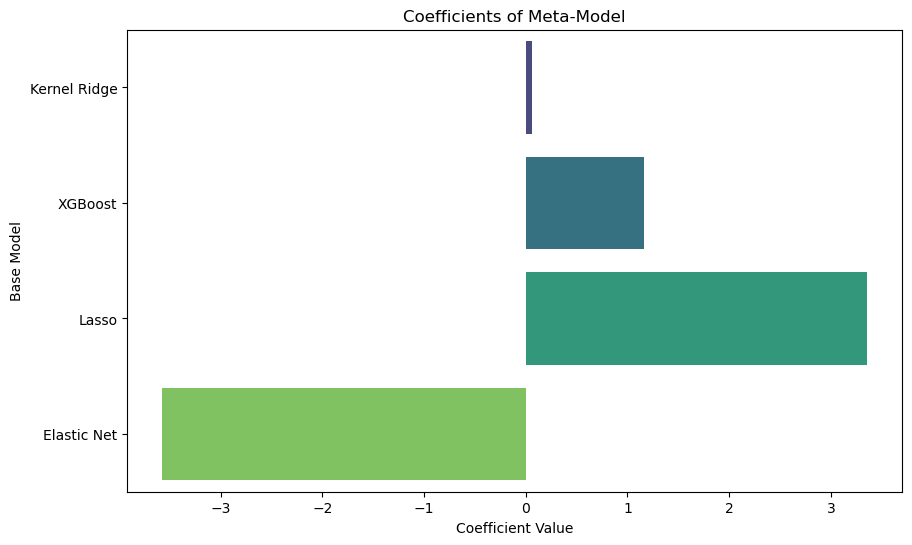

In [66]:
# Extract the coefficients of the meta-model
coefficients = meta_model.coef_
base_models = ['Kernel Ridge', 'XGBoost', 'Lasso', 'Elastic Net']

# Create a DataFrame for better visualization
import pandas as pd
coeff_df = pd.DataFrame({'Base Model': base_models, 'Coefficient': coefficients})

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Base Model', data=coeff_df, palette='viridis')
plt.title('Coefficients of Meta-Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Base Model')
plt.show()

In [67]:
## use this meta learner for the pred on test set
## and save preds for submission
# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(test_data_proc)
xgb_test_pred = xgb_best.predict(test_data_proc)
lasso_test_pred = lasso_best.predict(test_data_proc)
elastic_net_test_pred = elastic_net_best.predict(test_data_proc)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_4mods.csv",index=False)


regression valid set

In [70]:
from sklearn.linear_model import LinearRegression

# Generate predictions from each base model on the training set
kr_val_pred = kr_best.predict(X_val)
xgb_val_pred = xgb_best.predict(X_val)
lasso_val_pred = lasso_best.predict(X_val)
elastic_net_val_pred = elastic_net_best.predict(X_val)

# Stack predictions to create a new feature set for the meta-model
stacked_val_pred = np.column_stack((kr_val_pred, xgb_val_pred, lasso_val_pred, elastic_net_val_pred))

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_val_pred, y_val)

stacked_val_pred=meta_model.predict(stacked_val_pred)



# Evaluate the performance of the stacked model
mse_val = mean_squared_error(y_val, stacked_val_pred)
rmse_val = np.sqrt(mse_val)
print(f"Test RMSE of the stacked model: {test_rmse}")

Test RMSE of the stacked model: 0.07675538295317386


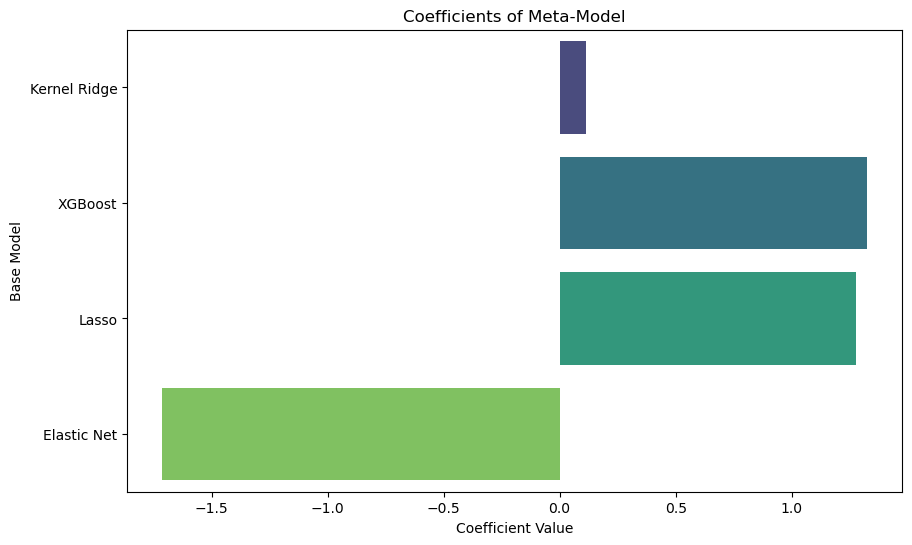

In [71]:
# Extract the coefficients of the meta-model
coefficients = meta_model.coef_
base_models = ['Kernel Ridge', 'XGBoost', 'Lasso', 'Elastic Net']

# Create a DataFrame for better visualization
import pandas as pd
coeff_df = pd.DataFrame({'Base Model': base_models, 'Coefficient': coefficients})

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Base Model', data=coeff_df, palette='viridis')
plt.title('Coefficients of Meta-Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Base Model')
plt.show()

In [72]:
## use this meta learner for the pred on test set
## and save preds for submission
# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(test_data_proc)
xgb_test_pred = xgb_best.predict(test_data_proc)
lasso_test_pred = lasso_best.predict(test_data_proc)
elastic_net_test_pred = elastic_net_best.predict(test_data_proc)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_4mods_val.csv",index=False)


## lets try a lasso meta learner

In [82]:

# Generate predictions from each base model on the training set
kr_train_pred = kr_best.predict(X_train)
xgb_train_pred = xgb_best.predict(X_train)
lasso_train_pred = lasso_best.predict(X_train)
elastic_net_train_pred = elastic_net_best.predict(X_train)

# Stack predictions to create a new feature set for the meta-model
stacked_train_pred = np.column_stack((kr_train_pred, xgb_train_pred, lasso_train_pred, elastic_net_train_pred))

# Train the meta-model
meta_model = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, random_state=42)

meta_model.fit(stacked_train_pred, y_train)
print(meta_model.alpha_)


# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(X_val)
xgb_test_pred = xgb_best.predict(X_val)
lasso_test_pred = lasso_best.predict(X_val)
elastic_net_test_pred = elastic_net_best.predict(X_val)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# Evaluate the performance of the stacked model
mse_val = mean_squared_error(y_val, final_predictions)
rmse_val = np.sqrt(mse_val)
print(f"Test RMSE of the stacked model: {test_rmse}")

0.0001
Test RMSE of the stacked model: 0.07675538295317386


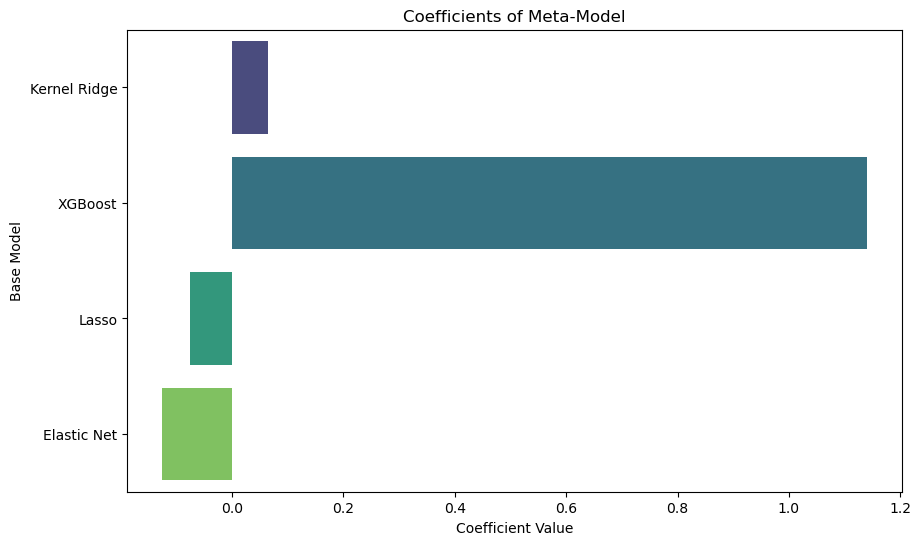

In [83]:
# Extract the coefficients of the meta-model
coefficients = meta_model.coef_
base_models = ['Kernel Ridge', 'XGBoost', 'Lasso', 'Elastic Net']

# Create a DataFrame for better visualization
import pandas as pd
coeff_df = pd.DataFrame({'Base Model': base_models, 'Coefficient': coefficients})

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Base Model', data=coeff_df, palette='viridis')
plt.title('Coefficients of Meta-Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Base Model')
plt.show()

In [84]:
## use this meta learner for the pred on test set
## and save preds for submission
# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(test_data_proc)
xgb_test_pred = xgb_best.predict(test_data_proc)
lasso_test_pred = lasso_best.predict(test_data_proc)
elastic_net_test_pred = elastic_net_best.predict(test_data_proc)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_4mods_lassometa.csv",index=False)


array([0., 0., 0., 0.])